In [1]:
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
import numpy as np

In [3]:
# b = '/home/yaxin/caries/caries_img _t/274.png'

# b = Image.open(b)
# b = np.array(b)
# print(b.shape)

In [2]:
img_paths = []
img_dir = '/home/yaxin/caries/only_caries_img'
img_dirs = os.listdir(img_dir)

for i in img_dirs:
    sub_dir =os.path.join(img_dir, i)
    img_paths.append(sub_dir)
    img_paths = sorted(img_paths, key=lambda x:int(x.split('/')[-1].split('.')[0]))
# print(img_paths)#/home/yaxin/caries/caries_img/345.jpg'
#sorted
#https://blog.csdn.net/qq_44703886/article/details/113680859

In [3]:
mask_paths = []
mask_dir = '/home/yaxin/caries/only_caries_mask'
mask_dirs = os.listdir(mask_dir)

for i in mask_dirs:
    sub_dir =os.path.join(mask_dir, i)
    mask_paths.append(sub_dir)
    # mask_paths = sorted(mask_paths, key=lambda x:int(x.split('/')[-1].split('.')[0]))
# print(mask_paths)

In [4]:
print(len(img_paths),len(mask_paths))

75 75


In [5]:
# split data: train & test
from sklearn.model_selection import train_test_split
image_paths_train, image_paths_test, mask_paths_train, mask_paths_test = train_test_split(
        img_paths, mask_paths, test_size=0.2,  random_state=42)

In [6]:
print(len(image_paths_train),len(image_paths_test),len(mask_paths_train),len(mask_paths_test))

60 15 60 15


Data Augment
https://www.kaggle.com/code/preyanshagrawal/mimo-unet

In [7]:
import random
import torchvision.transforms as transforms
import torchvision.transforms.functional as F


class PairRandomCrop(transforms.RandomCrop):

    def __call__(self, image, label):

        if self.padding is not None:
            image = F.pad(image, self.padding, self.fill, self.padding_mode)
            label = F.pad(label, self.padding, self.fill, self.padding_mode)

        # pad the width if needed
        if self.pad_if_needed and image.size[0] < self.size[1]:
            image = F.pad(image, (self.size[1] - image.size[0], 0), self.fill, self.padding_mode)
            label = F.pad(label, (self.size[1] - label.size[0], 0), self.fill, self.padding_mode)
        # pad the height if needed
        if self.pad_if_needed and image.size[1] < self.size[0]:
            image = F.pad(image, (0, self.size[0] - image.size[1]), self.fill, self.padding_mode)
            label = F.pad(label, (0, self.size[0] - image.size[1]), self.fill, self.padding_mode)

        i, j, h, w = self.get_params(image, self.size)

        return F.crop(image, i, j, h, w), F.crop(label, i, j, h, w)

class PairCompose(transforms.Compose):
    def __call__(self, image, label):
        for t in self.transforms:
            image, label = t(image, label)
        return image, label

class PairToTensor(transforms.ToTensor):
    def __call__(self, pic, label):
        """
        Args:
            pic (PIL Image or numpy.ndarray): Image to be converted to tensor.
        Returns:
            Tensor: Converted image.
        """
        return F.to_tensor(pic), F.to_tensor(label)

Ｄａｔａｓｅｔ

In [8]:
class Caries(Dataset):
     
    def __init__(self, img_paths, mask_paths, img_transform=None, target_transform=None,co_transform=None,use_binary_mask=True):#
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.transform = img_transform
        
    def __len__(self):
        return len(self.mask_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB') 
        mask_path =self.mask_paths[idx]
        mask = Image.open(mask_path).convert('L')
        if self.transform:
            image, mask = self.transform(image, mask)
        else:
            image = F.to_tensor(image)
            mask = F.to_tensor(mask)
        return image, mask 

In [129]:
# class Caries(Dataset):
     
#     def __init__(self, img_paths, mask_paths, img_transform=None, target_transform=None,co_transform=None,use_binary_mask=True):
#         self.img_paths = img_paths
#         self.mask_paths = mask_paths
#         self.transform = img_transform
#         self.target_transform = target_transform

#     def __len__(self):
#         return len(self.mask_paths)

#     def __getitem__(self, idx):
#         img_path = self.img_paths[idx]
#         image = Image.open(img_path).convert('RGB') 
#         mask_path =self.mask_paths[idx]
#         mask = Image.open(mask_path).convert('L')
#         # image_array = np.array(image)
#         # height, width = image_array[:2]
#         # if height.all() > width.all() :
#         #     image = image.rotate(90)

#         if self.transform:
#             # image, mask = self.transform(image, mask)
#             image = self.transform(image)
#             # mask = self.transform(mask)
#         if self.target_transform:
#             mask = self.target_transform(mask)
#         # if self.co_transform is not None:
#         #     img, mask = self.co_transform(img, mask) # ADDED THIS
#         return image, mask 

In [130]:
# transform = transforms.Compose([
#     # transforms.RandomCrop(400),
#     transforms.Resize([308,512]),
#     # transforms.Resize([570,786]),
#     transforms.ToTensor() 
#     ])

In [164]:
# train_dataset = Caries(image_paths_train, mask_paths_train, transform,transform)
# test_dataset = Caries(image_paths_test, mask_paths_test, transform,transform)

In [9]:
transform = PairCompose(
            [
                PairRandomCrop(512),
                PairToTensor()
            ]
        )


In [10]:
train_dataset = Caries(image_paths_train, mask_paths_train, transform)#, transform,transform
test_dataset = Caries(image_paths_test, mask_paths_test, transform)#,, transform,transform

In [11]:
img0, mask0 = train_dataset[5]

In [12]:
mask0

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [13]:
#check
print(img0.shape,mask0.shape)

torch.Size([3, 512, 512]) torch.Size([1, 512, 512])


(-0.5, 511.5, 511.5, -0.5)

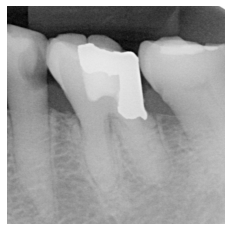

In [14]:
plt.imshow(img0.moveaxis(0, -1).numpy(), cmap='gray')
plt.axis('off')

(-0.5, 511.5, 511.5, -0.5)

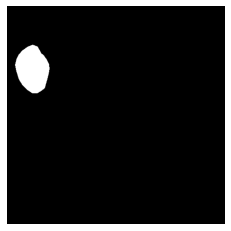

In [15]:
plt.imshow(mask0.moveaxis(0, -1).numpy(), cmap='gray')
plt.axis('off')

In [16]:
#check
print(len(train_dataset),
len(test_dataset))

60 15


Ｄａｔａ　Ｌｏａｄｅｒ

In [17]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True,drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True,drop_last=True)

Error: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])-->batch=1, add'drop_last=True'
 如果数据集大小不能被batch_size整除，设置为True可删除最后一个不完整的批处理。
 test57 /batch 4= 餘1

In [18]:
img_batch, mask_batch = next(iter(train_dataloader))

In [19]:
#check
img_batch.shape
mask_batch.shape

torch.Size([4, 1, 512, 512])

(-0.5, 511.5, 511.5, -0.5)

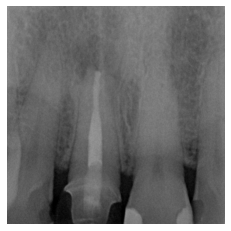

In [20]:
plt.imshow(img_batch[2].moveaxis(0, -1).numpy(), cmap='gray')
plt.axis('off')

(-0.5, 511.5, 511.5, -0.5)

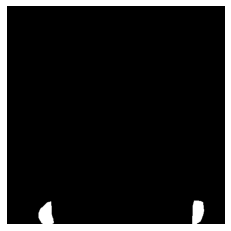

In [21]:
#check
# plt.imshow(img_batch[0].moveaxis(0, -1).numpy(), cmap='gray')
plt.imshow(mask_batch[2].moveaxis(0, -1).numpy(), cmap='gray')
plt.axis('off')


In [22]:
X, Y = iter(train_dataloader).next()

Ｍｏｄｅｌ

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [276]:
# model = UNet(n_channels=3, n_classes=1, bilinear=True)
# model.to(device)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [24]:
import model
from model.deeplabv3plus import DeepLabv3_plus 

In [28]:
model = DeepLabv3_plus()
# model = UNet(n_channels=3, n_classes=1, bilinear=True)
# modelAttentionUNet=AttentionUNet()
model.to(device)

Constructing DeepLabv3+ model...
Number of classes: 1
Output stride: 16
Number of Input Channels: 3


DeepLabv3_plus(
  (resnet_features): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequent

In [29]:
if torch.cuda.is_available():
    model.cuda()

In [30]:
X = X.cuda() #error:Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([4, 1, 512, 512])


/home/yaxin/.local/lib/python3.8/site-packages/torch/nn/functional.py:3704: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [31]:
print(len(train_dataset), len(train_dataloader))
X, Y = iter(train_dataloader).next()
print(X.shape, Y.shape)

60 15
torch.Size([4, 3, 512, 512]) torch.Size([4, 1, 512, 512])


Ｏptimizer　／ Training and testing functions

In [52]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [32]:
# loss_fn =nn.BCELoss()
loss_fn =nn.BCEWithLogitsLoss()
# loss_fn =DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,weight_decay=0.0001)

In [33]:
def dice(input, target):
    smooth = 1.0

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return (2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth)

In [34]:
from torch.utils.tensorboard import SummaryWriter 
writer = SummaryWriter('/home/yaxin/caries/loop_result')

In [35]:
train_losses = []
test_losses =[]
test_dicees = []
num_epochs=300

for epoch in (range(num_epochs)):
    train_loss = 0
    size = len(train_dataloader.dataset)
    for batch, (X, y) in enumerate(train_dataloader):
        X = X.cuda()
        y = y.cuda().float()
        Y_pred = model(X)
        loss = loss_fn(Y_pred, y)
        # loss = loss_fn(torch.sigmoid(Y_pred), y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            train_loss, current = loss.item(), batch * len(X)


    num_batches = len(test_dataloader)
    test_loss, test_dice = 0, 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X = X.cuda()
            y = y.cuda().float()
#             X = X.to(device)
#             y = y.to(device).float()
            pred = model(X)
            pred = torch.sigmoid(pred)
            test_loss += loss_fn(pred,y).item()
            # pred = torch.sigmoid(pred)
            test_dice += dice(y,pred)
    test_loss /= num_batches
    test_dice /= num_batches
    test_dice = test_dice.cpu().numpy()

    writer.add_scalar('train_loss', train_loss, epoch+1)
    writer.add_scalar('test_loss', test_loss, epoch+1)   
    writer.add_scalar('test_dice', test_dice, epoch+1)  
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_dicees.append(test_dice)
    
    print("Epoch:{}/{} \n".format(epoch+1, num_epochs),
                f"training loss: {train_loss:>7f}  [{current:>5d}/{size:>5d}] \n",
                f"Test Error: Avg Dice: {test_dice:>5f}, Avg loss: {test_loss:>8f} \n")
writer.close() 

Epoch:1/300 
 training loss: 0.424757  [    0/   60] 
 Test Error: Avg Dice: 0.022800, Avg loss: 0.711757 

Epoch:2/300 
 training loss: 0.091281  [    0/   60] 
 Test Error: Avg Dice: 0.030144, Avg loss: 0.708522 

Epoch:3/300 
 training loss: 0.103538  [    0/   60] 
 Test Error: Avg Dice: 0.022618, Avg loss: 0.701906 

Epoch:4/300 
 training loss: 0.030333  [    0/   60] 
 Test Error: Avg Dice: 0.016952, Avg loss: 0.703537 

Epoch:5/300 
 training loss: 0.096866  [    0/   60] 
 Test Error: Avg Dice: 0.029645, Avg loss: 0.701679 

Epoch:6/300 
 training loss: 0.056802  [    0/   60] 
 Test Error: Avg Dice: 0.039381, Avg loss: 0.702710 

Epoch:7/300 
 training loss: 0.114669  [    0/   60] 
 Test Error: Avg Dice: 0.071663, Avg loss: 0.704099 

Epoch:8/300 
 training loss: 0.056199  [    0/   60] 
 Test Error: Avg Dice: 0.069163, Avg loss: 0.702186 

Epoch:9/300 
 training loss: 0.057267  [    0/   60] 
 Test Error: Avg Dice: 0.043825, Avg loss: 0.700079 

Epoch:10/300 
 training loss

Text(0.5, 1.0, 'test_dicees')

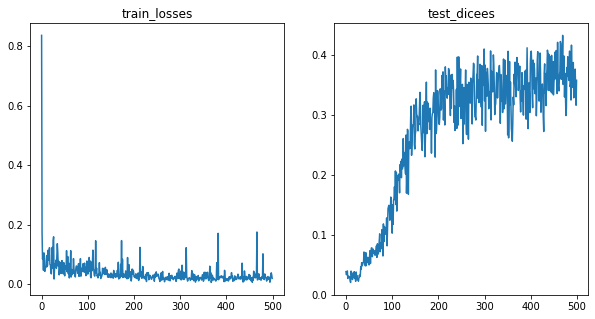

In [284]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# plt.ylim(ymin=0, ymax=1)#默認情況下，matplotlib的坐標軸刻度並不會從0開始，ylim()設置y軸範圍。讓y軸的刻度從0開始
axes[0].plot(train_losses)
axes[0].set_title("train_losses")
axes[1].plot(test_dicees)
axes[1].set_title("test_dicees")

In [285]:
FILE = '/home/yaxin/caries/model/UNet_allcrop500.pt'
torch.save({
                'epoch': 500,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss_fn,
                'dice': dice 
                }, FILE)

Check predictions

In [36]:
X, Y = next(iter(test_dataloader))
X, Y = X.to(device), Y.to(device)
Y_pred = model(X.to(device))
# Y_pred[Y_pred>0.5]=1
# Y_pred[Y_pred<=0.5]=0
print(Y_pred.shape)

torch.Size([4, 1, 512, 512])


In [37]:
inverse_transform =transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

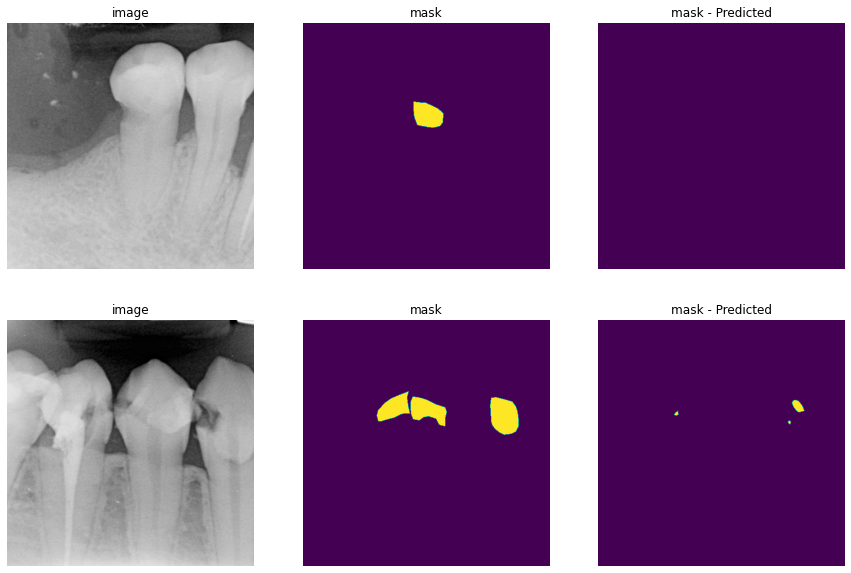

In [38]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 3, figsize=(3*5,2*5))



for i in range(2):

    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = inverse_transform(Y[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class_predicted = Y_pred[i][0].cpu().detach().numpy()

#     print(label_class_predicted.shape)
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("image")
    axes[i, 0].axis('off')
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("mask")
    axes[i, 1].axis('off')
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("mask - Predicted")
    axes[i, 2].axis('off')
